## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
The goal is to group countries using socio-economic and health factors to determine the development status of the countries.

In [1]:
# Import libraries.
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed.
rseed = 42

## Load and explore data

In [3]:
# Import the dataset.
# Using a try-except block to catch and handle potential errors.
try:
    # Read in the 'Country-data.csv' file.
    country_df = pd.read_csv('Country-data.csv')
# Using 'except FileNotFoundError' to handle the case where the
# 'Country-data.csv' file does not exist and display an informative message.
except FileNotFoundError:
    print("Error: Country-data.csv not found.")
    # Exit the program if the file is not found.
    exit()

# Display the first 5 observations.
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# Check the shape.
country_df.shape
# (the dataset has 167 rows and 10 columns)

(167, 10)

In [5]:
# Check datatypes & counts.
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
# Get descriptive statistics.
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
# Identify any missing data.
missing_values_count = country_df.isnull().sum()
print(missing_values_count)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


There are no missing data values in the dataset.

## Preprocessing and Feature Selection

In [8]:
# Drop any non-numeric features (columns).
# Drop the 'country' column, which is the only non_numeric column in the
# dataset.
numeric_df = country_df.drop(['country'], axis=1)
print("\nFirst 5 rows of the numeric dataframe after dropping the 'country' column:")
numeric_df.head()


First 5 rows of the numeric dataframe after dropping the 'country' column:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Text(0.5, 1.0, 'Correlation Map of Features')

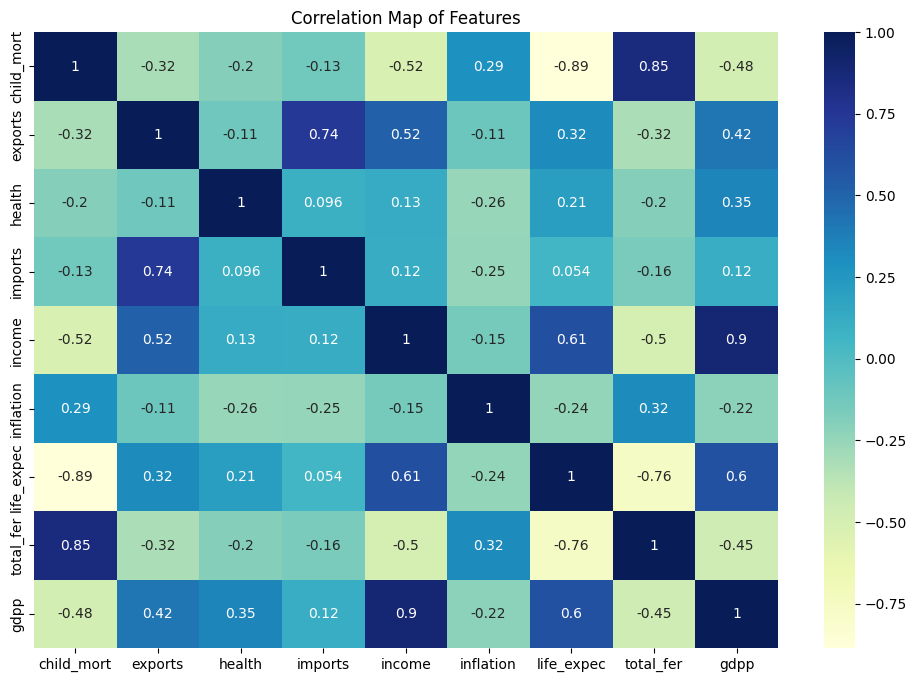

In [9]:
# Create a correlation map of features to explore relationships between features.
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Map of Features')

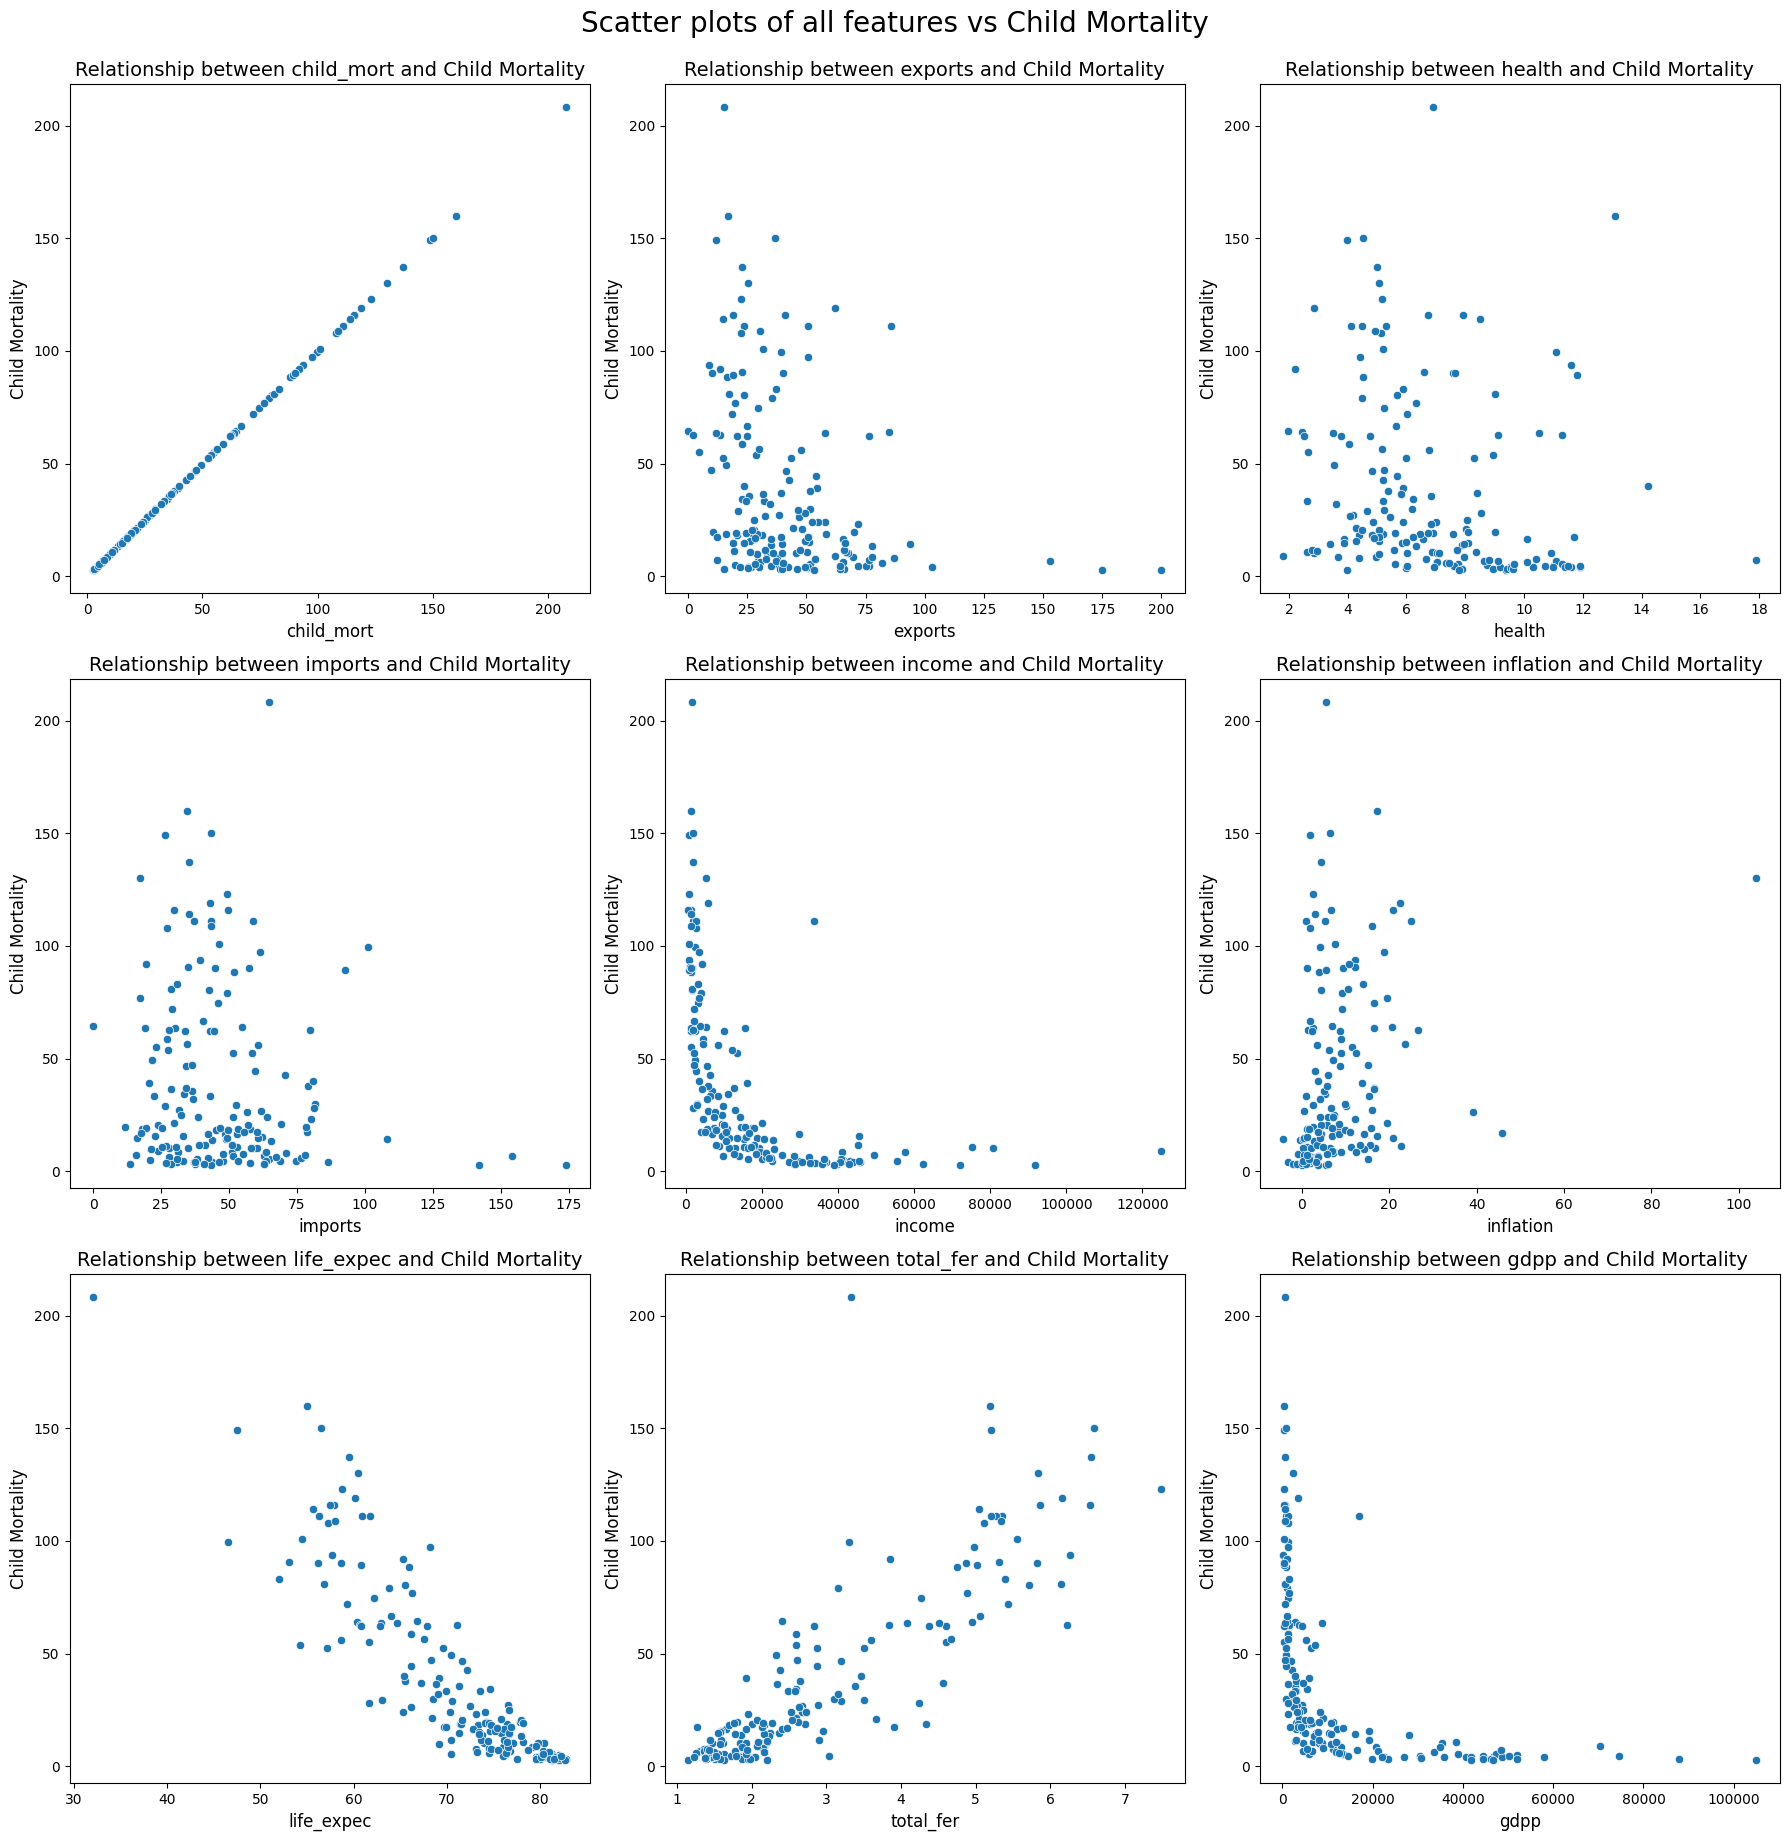

In [ ]:
# Explore the continuous independent features against child_mort using scatter plots.
# Create a figure with 3 rows and 3 columns for all 9 plots.
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

# Iterate through all the features and plot a scatter plot for each
# feature against 'child_mort'.
for i, feature in enumerate(numeric_df.columns):
    sns.scatterplot(x=numeric_df[feature], y=numeric_df['child_mort'], data=numeric_df, ax=axes[i])
    axes[i].set_title(f'Relationship between {feature} and Child Mortality', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Child Mortality', fontsize=12)

plt.tight_layout()
plt.suptitle('Scatter plots of all features vs Child Mortality', y=1.02, fontsize=20)
plt.show()

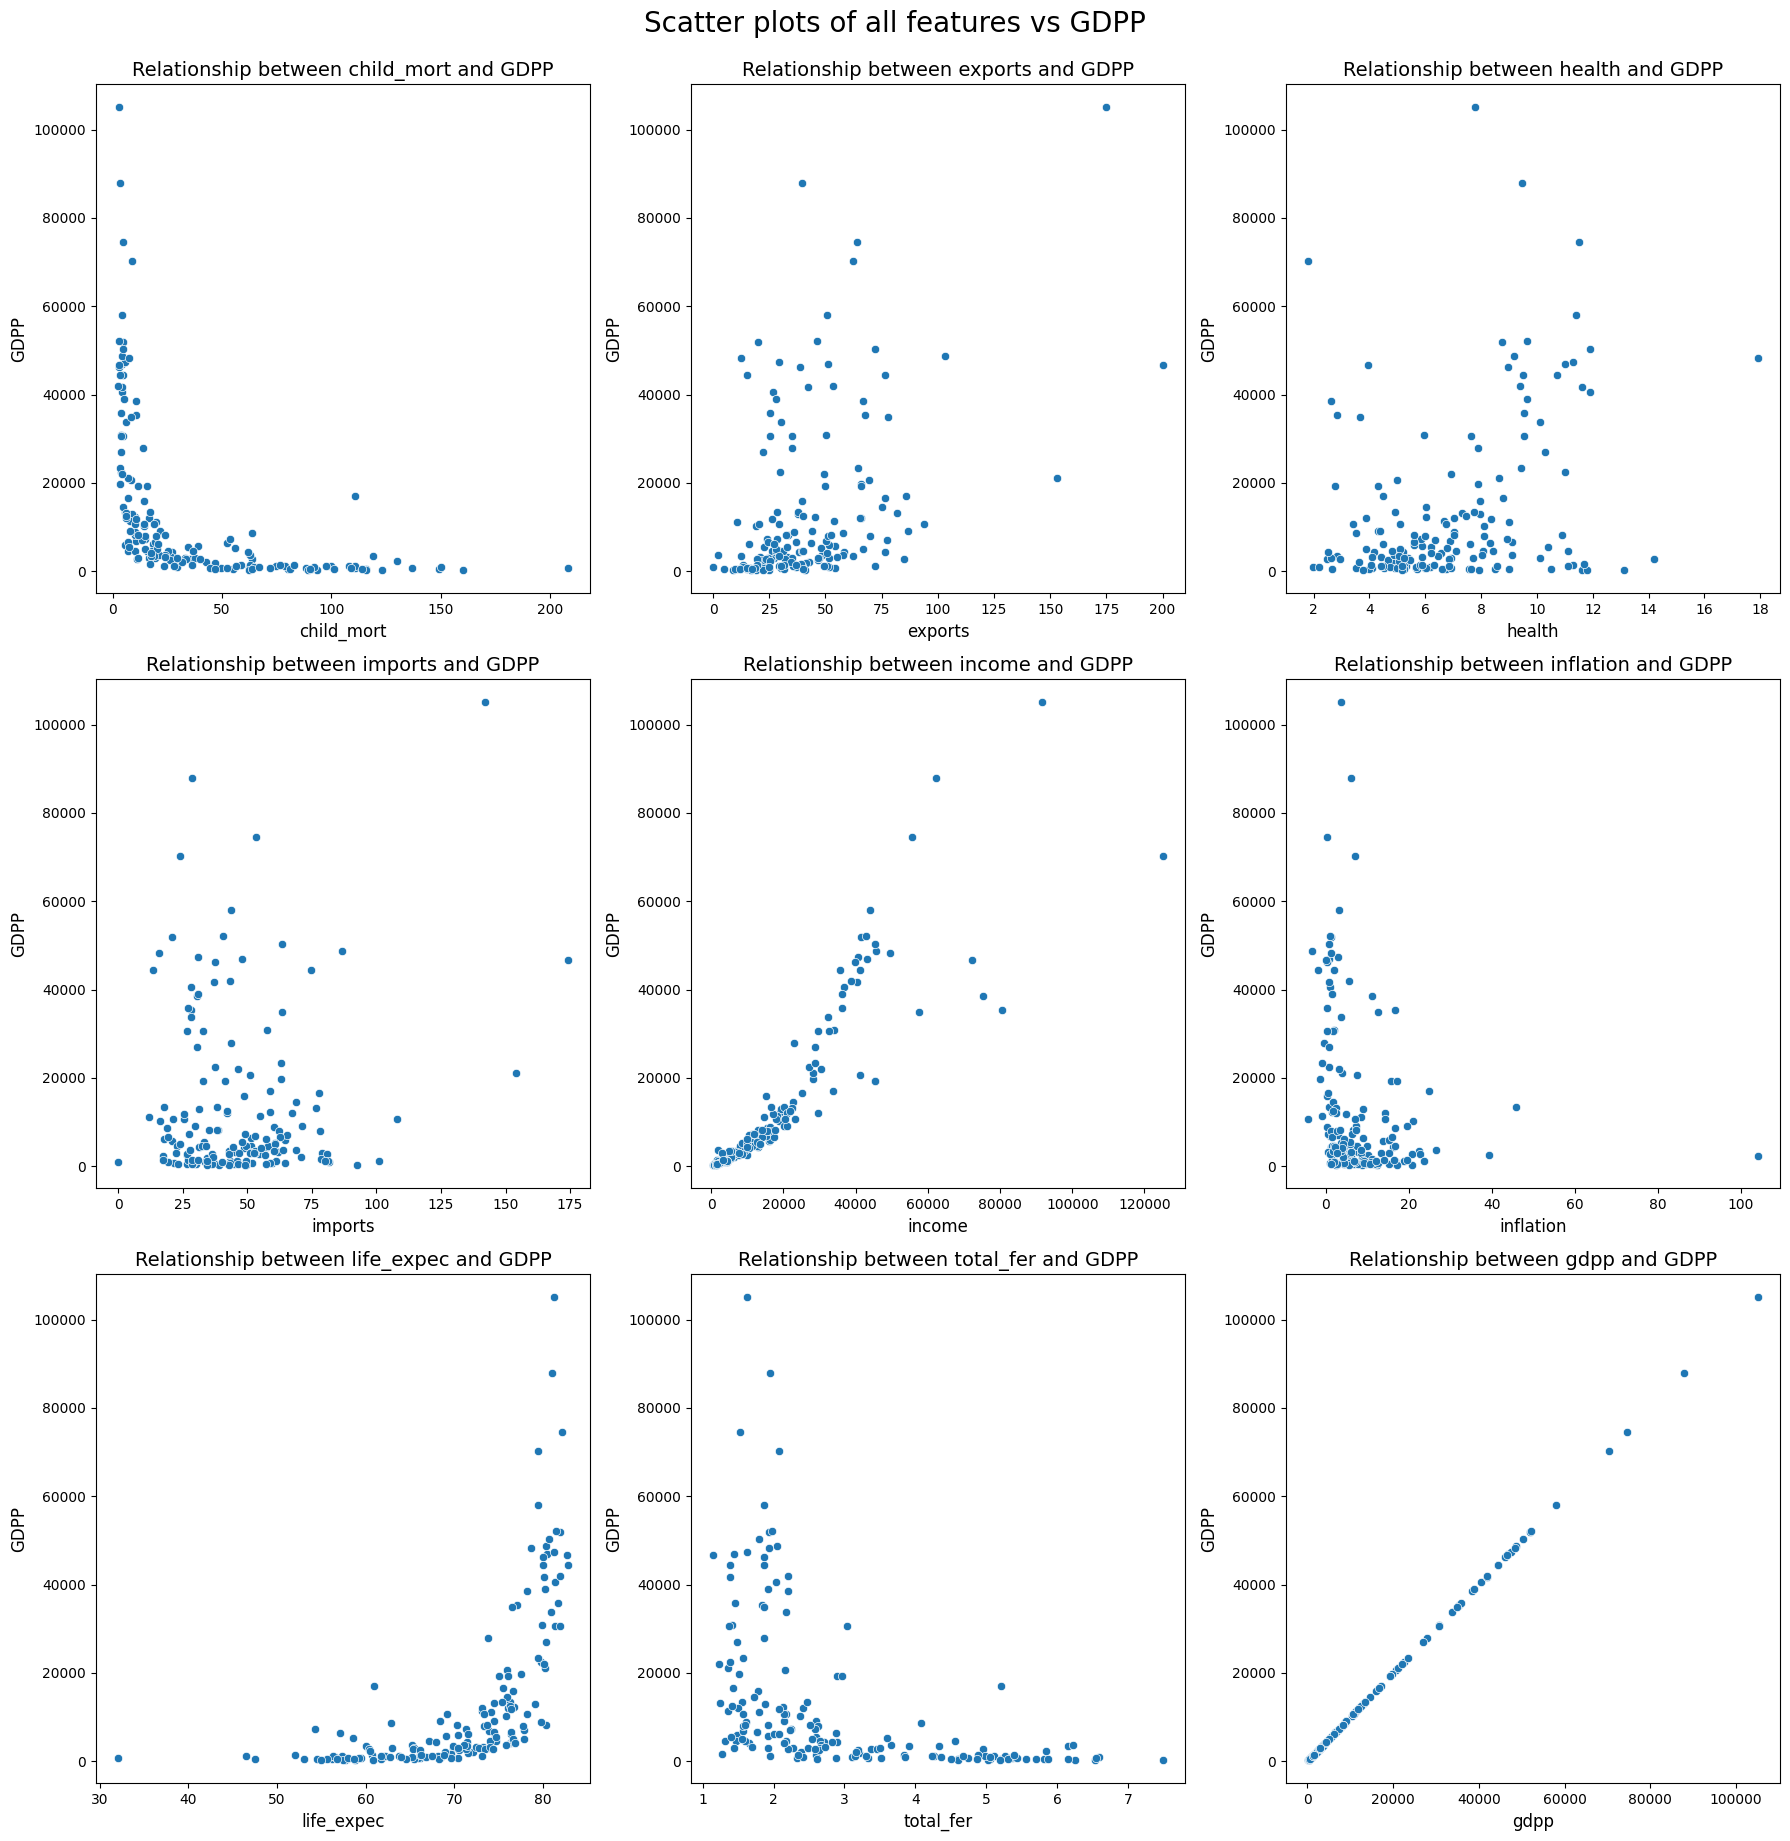

In [11]:
# Explore the continuous independent features against gdpp using scatter plots.
# Create a figure with 3 rows and 3 columns for all 9 plots.
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

# Iterate through all the features and plot a scatter plot for each
# feature against 'gdpp'.
for i, feature in enumerate(numeric_df.columns):
  sns.scatterplot(x=numeric_df[feature], y=numeric_df['gdpp'], data=numeric_df, ax=axes[i])
  axes[i].set_title(f'Relationship between {feature} and GDPP', fontsize=14)
  axes[i].set_xlabel(feature, fontsize=12)
  axes[i].set_ylabel('GDPP', fontsize=12)

plt.tight_layout()
plt.suptitle('Scatter plots of all features vs GDPP', y=1.02, fontsize=20)
plt.show()

* Note which of these plots looks the most promising for separating into clusters.

From the scatterplots above, the plots that looks the most promising for separating into clusters are 'child_mort' vs 'gdpp', 'income' vs 'gdpp', 'inflation' vs 'gdpp', 'life_expec' vs 'gdpp' and 'total_fer' vs 'gdpp' because they form distinct patterns or groups.

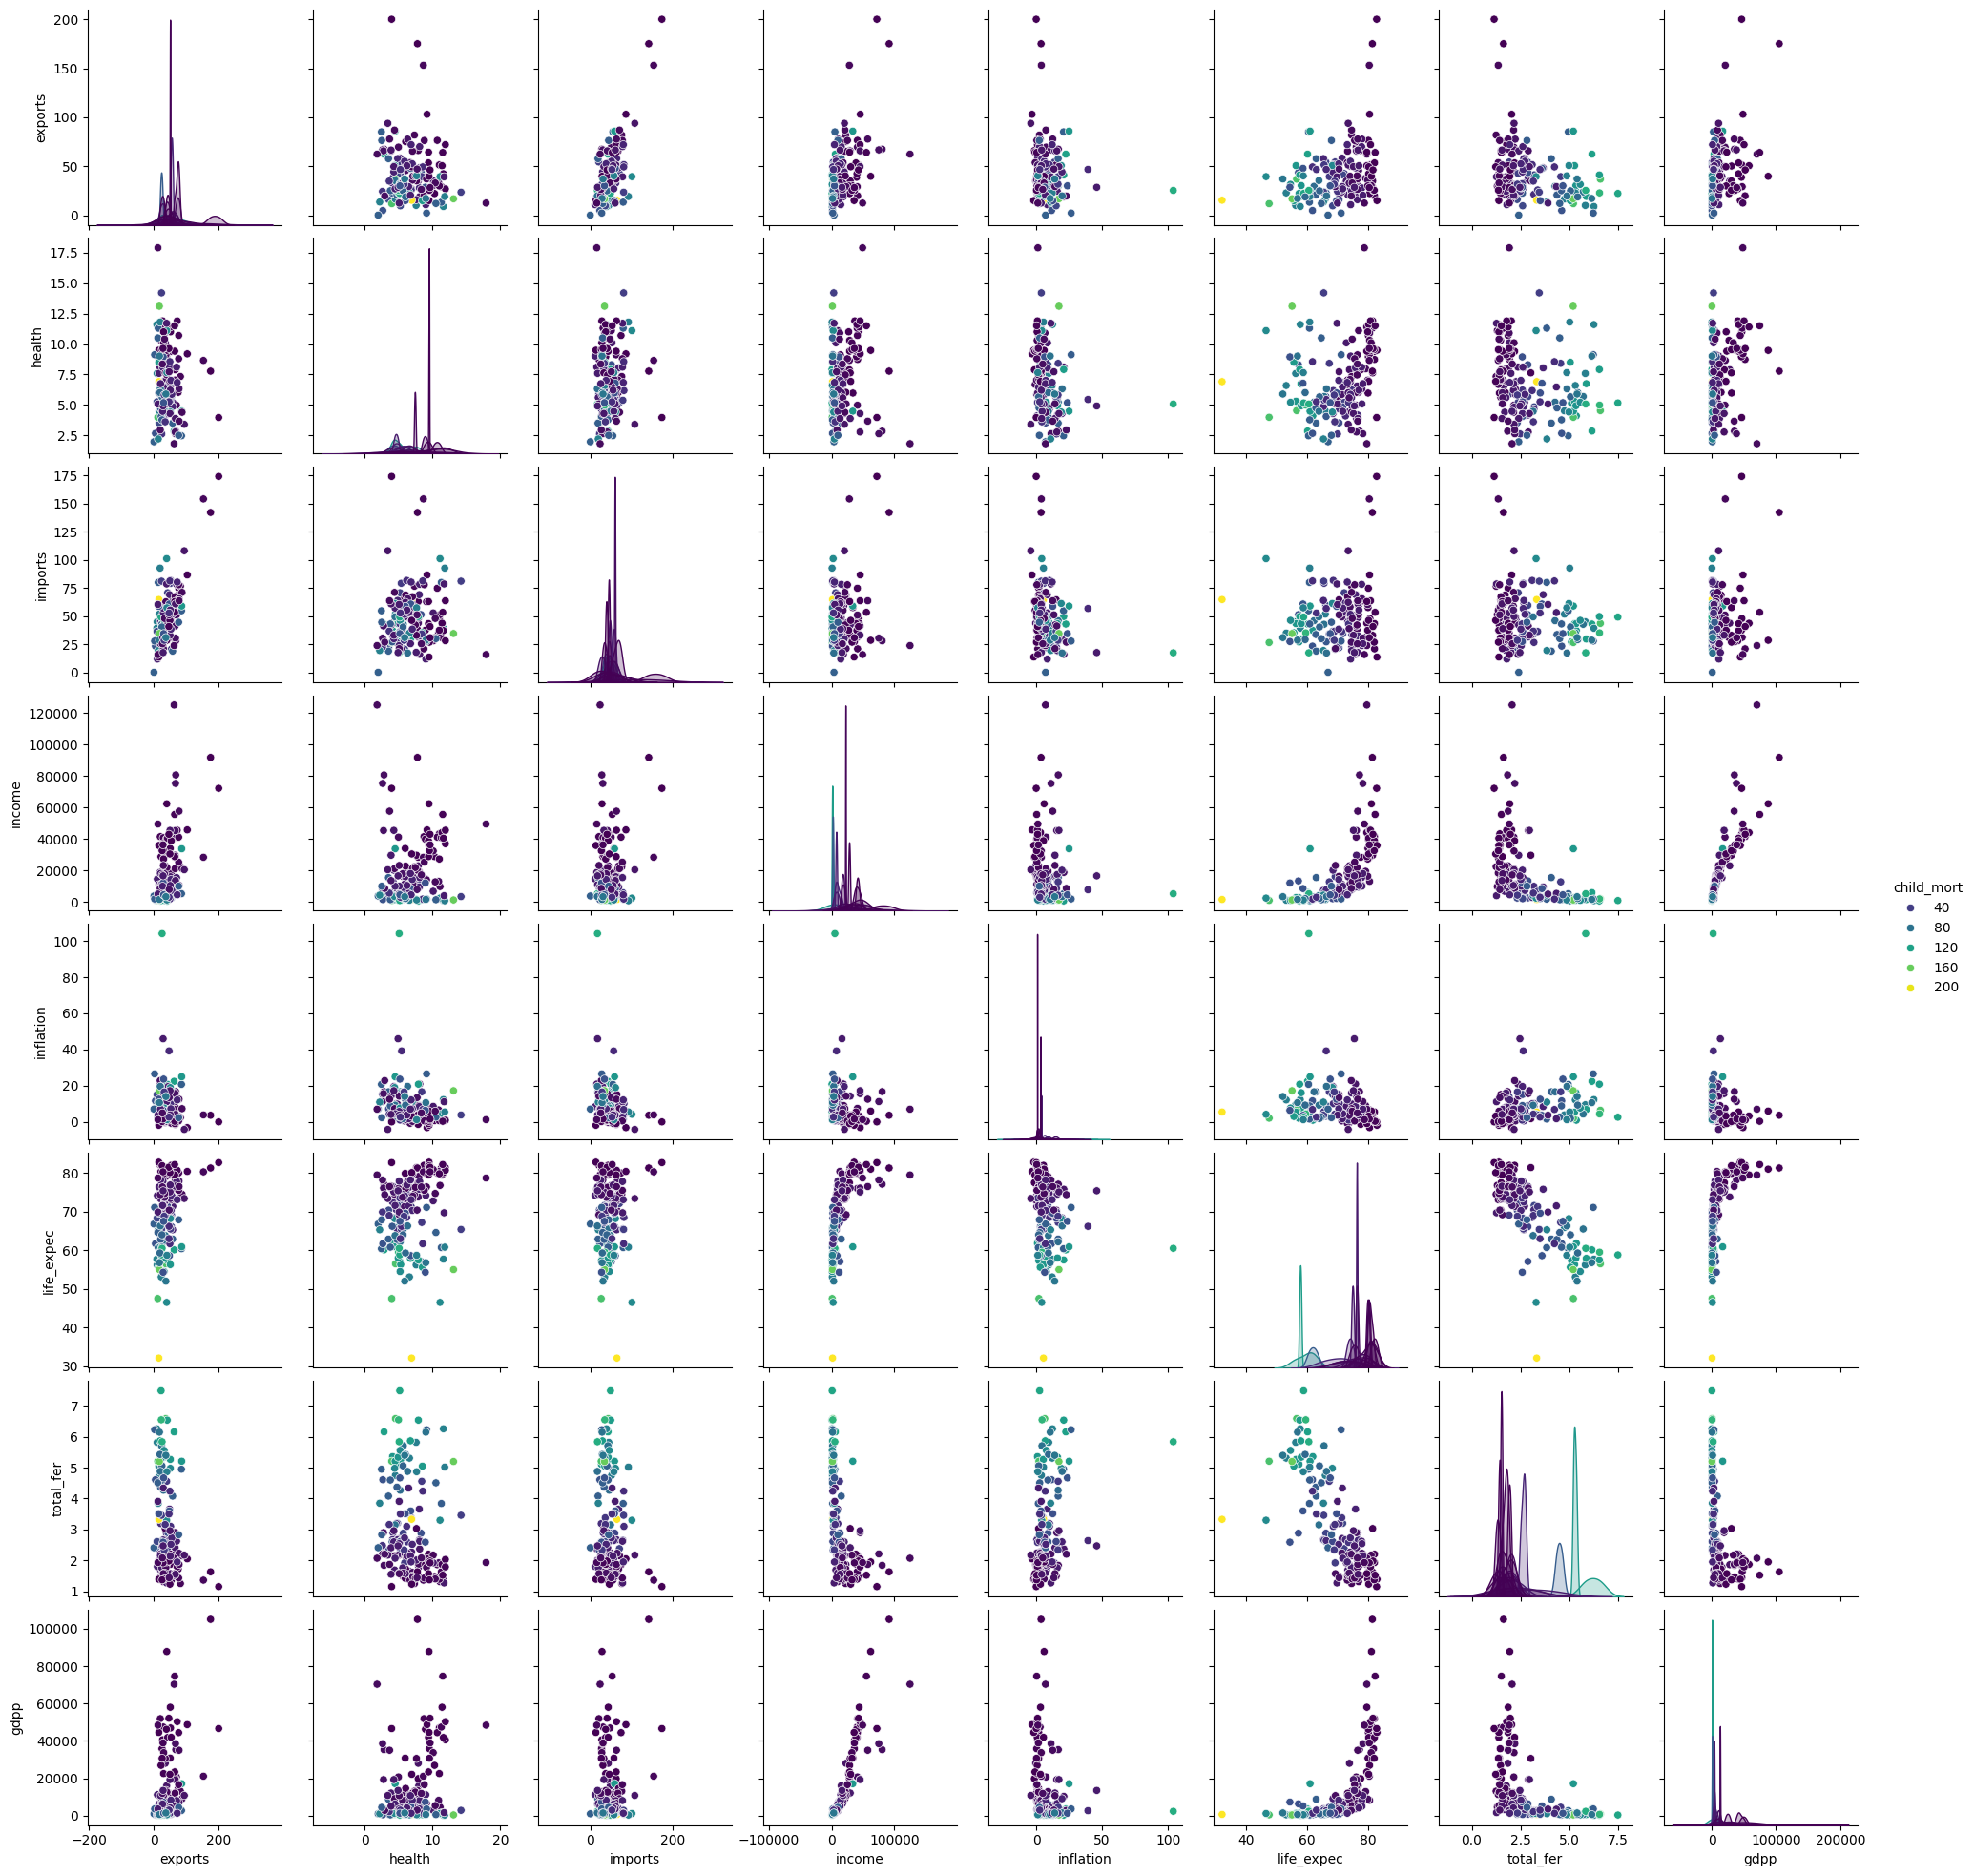

In [12]:
# Create a pair plot.
# Plot the distribution of the data to explore the data with visualisations.
sns.pairplot(data=numeric_df, hue='child_mort', palette='viridis')

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [13]:
# Normalise the data using MinMaxScaler.
# Initialize the scaler.
scaler = MinMaxScaler()

# Fit and transform the numeric data.
df_scaled = scaler.fit_transform(numeric_df)

# Convert the data into a dataframe and name the normalised dataframe
# "df_scaled".
df_scaled = pd.DataFrame(df_scaled, columns=numeric_df.columns)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

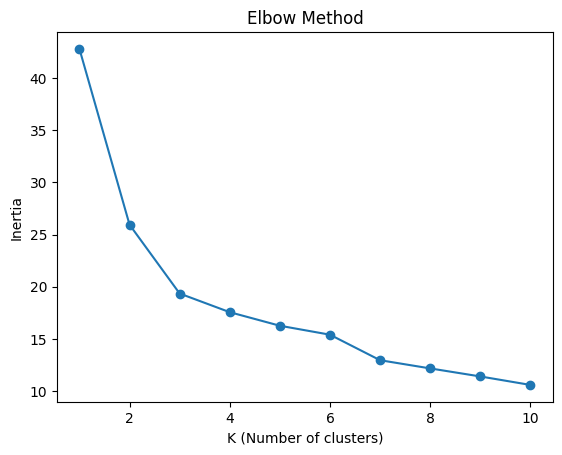

In [ ]:
# Plot elbow curve.
# Define function to calculate inertia.
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    # Calculate inertia for a range of k values (1 to max_k).
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    # Plot the elbow curve.
    plt.plot(range(1, 11), within_cluster_vars, marker='o')
    plt.xlabel('K (Number of clusters)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

# Plot elbow curve using scaled dataset.
elbow_Kmeans(df_scaled)

From the graph above, it looks like the elbow is at K=3 or K=4.

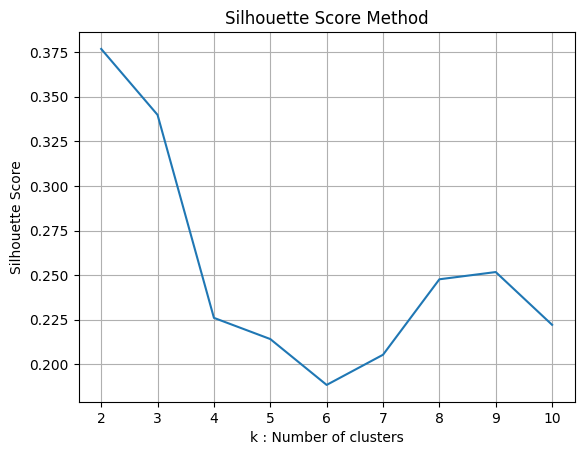

In [ ]:
# Silhouette score method.
kmax = 10
sil = []
plt.plot()
# Iterate through k values from 2 to kmax.
for k in range(2, kmax+1):
    # Initialize and fit K-means.
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    # Calculate and store the silhouette score.
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

# Plot the silhouette scores against the number of clusters (k).
sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

### Based on the elbow and silhouette score method choose a value for K.

From the above elbow method and silhouette score method plots, K=3 and K=4 are the most likely optimal number of clusters. If the silhouette score is closer to 1, it means that the clusters are better defined. Since K=3 have a higher silhouette score than K=4 and for the purpose of classifying the groups of countries (the clusters) into socio-economic development levels (least developed, developing and developed), I will choose K=3.

## Fitting a K-Means Model with the selected K value

In [16]:
# Fitting the K-means model to the scaled dataset.
k=3
kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=rseed)
kmeans.fit(df_scaled)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,1000
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [17]:
# Count the number of records in each cluster.
label = kmeans.labels_
label_counts = pd.Series(label).value_counts()
print(f"The number of records in each cluster is: \n{label_counts}")

The number of records in each cluster is: 
0    87
2    45
1    35
Name: count, dtype: int64


In [18]:
# Check model performance with the silhouette coefficient.
silhouette = silhouette_score(df_scaled, label)
print(f"The silhouette score for k = {k} is {silhouette}")

The silhouette score for k = 3 is 0.33976487765323604


## Predictions

In [19]:
# Add the predicted cluster label column to the original dataframe.
country_df["Clusters"] = label
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Clusters
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


## Visualisation of clusters

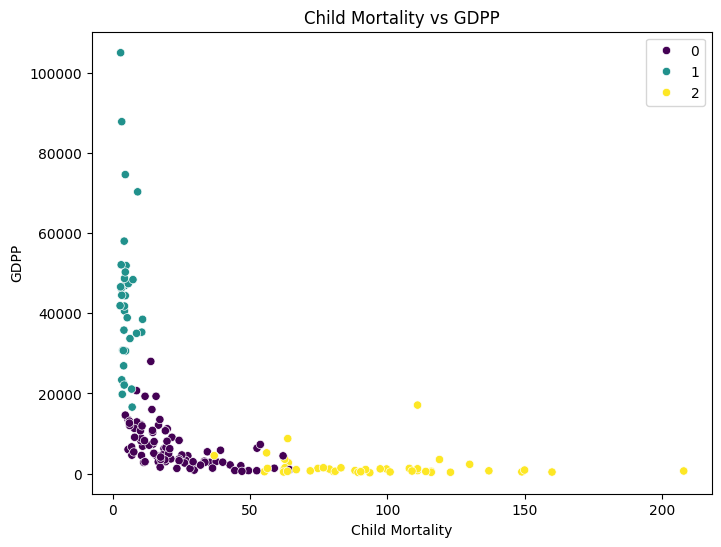

In [20]:
# Visualisation of clusters: child mortality vs gdpp.
# Create a scatter plot to visualize the clustering results in two
# dimensions (child mortality vs gdpp).
plt.figure(figsize=(8, 6))
sns.scatterplot(x=country_df['child_mort'], y=country_df['gdpp'], hue=label, palette='viridis', data=country_df)
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.title('Child Mortality vs GDPP')
plt.show()

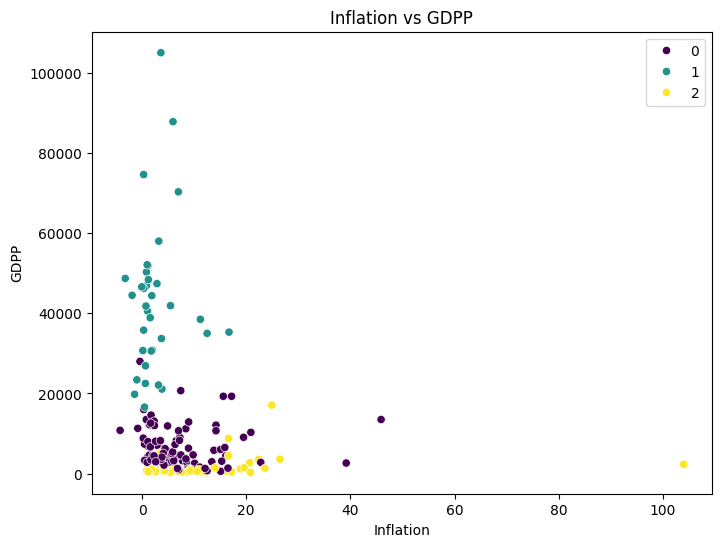

In [21]:
# Visualisation of clusters: inflation vs gdpp.
# Create a scatter plot to visualize the clustering results in two
# dimensions (inflation vs gdpp).
plt.figure(figsize=(8, 6))
sns.scatterplot(x=country_df['inflation'], y=country_df['gdpp'], hue=label, palette='viridis', data=country_df)
plt.xlabel("Inflation")
plt.ylabel("GDPP")
plt.title("Inflation vs GDPP")
plt.show()

In [22]:
# Calculate the mean values of key metrics for each cluster to profile them.
cluster_profile = country_df.groupby('Clusters')[['child_mort', 'gdpp', 'income', 'inflation',
                                           'life_expec', 'total_fer']].mean().sort_values(by='gdpp')

print("\nCluster Profiles (Mean values, sorted by GDPP in ascending order):")
cluster_profile


Cluster Profiles (Mean values, sorted by GDPP in ascending order):


,child_mort,gdpp,income,inflation,life_expec,total_fer
Clusters,,,,,,
2,94.733333,1704.933333,3555.400000,12.214556,59.342222,5.109111
0,22.490805,6657.379310,12644.482759,7.599839,72.457471,2.315632
1,4.897143,43117.142857,45802.857143,2.535000,80.245714,1.741143


In [ ]:
# Add the development status label of each country/cluster to the original dataframe.
country_df["Development status"] = country_df['Clusters'].map({0: 'Developing', 1: 'Developed', 2: 'Least Developed'})
country_df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Clusters,Development status
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,2,Least Developed
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,0,Developing
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,0,Developing
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,2,Least Developed
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,0,Developing
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,0,Developing
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,0,Developing
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1,Developed
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,Developed
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,0,Developing


## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**


### Cluster labels: 

The clusters are labeled based on their mean values for key development indicators like GDPP, child mortality, inflation, income, life expectancy and total fertility.

Cluster 0 - Developing / Middle-Income: Countries in cluster 0 have moderate mean values across all metrics, consistently falling between the high-income (developed) and low-income (least developed) groups. These countries represents the bulk of the middle-tier of global development.

Cluster 1 - Developed / High-Income: Countries in cluster 1 have the highest mean GDPP, highest mean income and highest mean life expectancy. These countries also have the lowest mean child mortality, lowest mean inflation and lowest mean total fertility. These countries are classified as developed countries and have strong economies and good healthcare systems.

Cluster 2 - Least Developed / Low-Income: Countries in cluster 2 have the lowest mean GDPP, lowest mean income and lowest mean life expectancy. These countries also have the highest mean child mortality, highest mean inflation and highest mean total fertility. These countries are classified as the least developed countries and are facing economic constraints and healthcare challenges.


### From the cluster graphs:

The visualizations clearly show the separation of the three labeled groups (clusters).

Child Mortality vs GDPP


* Cluster 0: These countries are grouped between cluster 1 and 2 on the graph with medium GDPP and slightly elevated child mortality rates. These countries form a broad band between the two extremes. Countries in this cluster are developing countries.

* Cluster 1: These countries are grouped in the top-left of the graph with very high GDPP and extremely low child mortality rates. Countries in this cluster are developed countries.

* Cluster 2: These countries are grouped in the bottom-right of the graph with very low GDPP and very high child mortality rates. Countries in this cluster are the least developed.



Inflation vs GDPP

* Cluster 0: These countries are clustered between cluster 1 and 2 on the graph. They are distributed across a wide range of GDPP and inflation values, bridging the gap between the other two clusters. This cluster represents developing countries.

* Cluster 1: These countries are clustered in the middle-left to top-left of the graph at very high GDPP and low inflation, which corresponds to developed countries.

* Cluster 2: These countries are clustered in the bottom of the graph with very low GDPP and show a wide range of higher inflation, which corresponds to least developed countries.